# Introduction

## Import and settings

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.special import expit

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import networkx as nx

from lingam.causal_based_simulator import CausalBasedSimulator
from lingam.utils import make_dot

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Creatig test data
The test data `X` is a data frame such that only x2 is a discrete variable and the other variables are continuous variables. x2 has either 0 or 1.  
The matrix `G` of the causal graph is needed to estimate the functional relationship in CausalBasedSimulator. Although the matrix elements are numeric to generate test data, CausalBasedSimulator ignores that volume and uses only zero or nonzero.

### Causal graph

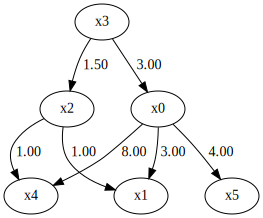

### Test data

,x0,x1,x2,x3,x4,x5
0,-0.725033,-0.853352,1,-0.298043,-5.518573,-3.361619
1,2.092471,5.580223,1,0.449011,17.970192,7.668833
2,3.251115,10.669606,1,0.965044,25.752890,11.510047
3,3.808976,13.150129,1,1.217832,30.951193,14.725043
4,3.023790,8.491654,1,1.096086,23.642615,11.167459


In [2]:
display(Markdown("### Causal graph"))

G = np.array([[0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [3.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.5, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

causal_order = [3, 2, 0, 4, 1, 5]

display(make_dot(G))

display(Markdown("### Test data"))

N = 1000
n_features = len(G)
discrete_index = 2

e = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(n_features, N))
X = np.empty((n_features, N))
for i in causal_order:
    X[i] = G[i] @ X + e[i]
    if i == discrete_index:
        X[i] = (expit(X[i]) >= np.random.uniform(size=N)).astype(int)
X = pd.DataFrame(X.T, columns=[f"x{i}" for i in range(n_features)])

X[f"x{discrete_index}"] = X[f"x{discrete_index}"].astype(int)

X.head()

## Estimating functional relationships between variables

Estimate functional relationships between variables by feeding test data to CausalBasedSimulator.

See the notebook *estimating_functional_felationships.ipynb* for more information.

In [3]:
sim = CausalBasedSimulator()
sim.train(X, G, is_discrete=[False, False, True, False, False, False])

Functional relationships between variables are stored in `train_result_`. The keys of the dictionary are the column names of `X` given to `train()`.

In [4]:
sim.train_result_.keys()

dict_keys(['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

The values of this dictionary has information about the model for that variable.

In [5]:
sim.train_result_["x1"].keys()

dict_keys(['model', 'parent_names', 'predicted', 'residual'])

This dictionary contains the following four elements:
- model
  - An instance of the machine learning model for the variable.
- parent_names
  - List of parent names.
- predicted
  - Predicted values by model.
- residual
  - Estimated error data.

`model` contains trained `sklearn.linear_model.LinearRegression` by default when the variable is a continuous variable, and `sklearn.linear_model.LogisticRegression` when the variable is a discrete variable.

In [6]:
# x1 is a continuous variable
type(sim.train_result_["x1"]["model"])

sklearn.linear_model._base.LinearRegression

In [7]:
# x2 is a discrete variable
type(sim.train_result_["x2"]["model"])

sklearn.linear_model._logistic.LogisticRegression

`parent_names` is a list of names of parents.

In [8]:
sim.train_result_["x1"]["parent_names"]

['x0', 'x2']

`parent_names` of the exogenous variable is a empty list.

In [9]:
sim.train_result_["x3"]["parent_names"]

[]

`predicted` is a list of predicted values and `residual` is a list of estimated error values. When `residual` is added to `predicted`, it equals test data of x2.

In [10]:
predicted = sim.train_result_["x1"]["predicted"]
residual = sim.train_result_["x1"]["residual"]

np.isclose(predicted + residual, X["x1"]).all()

True

`residual` of a discrete variable is None.

In [11]:
sim.train_result_["x2"]["residual"] is None

True

## Generating simulated data

By running train() in CausalBasedSimulator, you can simulate the data when the model and errors are replaced.

For more information, see the notebook *generating_simulated_data.ipynb*.

In [30]:
# new x0 data
changing_exog = {
    "x0": np.random.laplace(0, 10, size=X.shape[0]),
}

# new x0 model
parent_names = sim.train_result_["x0"]["parent_names"]
new_model = LinearRegression()
new_model.fit(X[parent_names].values, X["x0"].values * 10)

changing_models = {
        # the target variable name
        "x0": {
            # new instance of the model
            "model": new_model,
            # names of explanatory variables
            "parent_names": parent_names,
        },
}

sim_df = sim.run(changing_exog=changing_exog, changing_models=changing_models)

Check the data generated counterfactually.

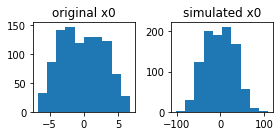

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].hist(X["x0"])
axes[0].set_title("original x0")
axes[1].hist(sim_df["x0"])
axes[1].set_title("simulated x0")
plt.tight_layout()
plt.show()

Another way to change the model is as follows:

In [37]:
# new x0 model
changing_models = {
        # the target variable name
        "x0": {
            # coefficient of new regression model
            "coef": [10],
            # names of explanatory variables
            "parent_names": parent_names,
        },
}

sim_df = sim.run(changing_models=changing_models)

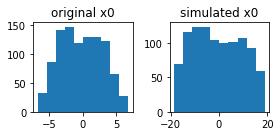

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].hist(X["x0"])
axes[0].set_title("original x0")
axes[1].hist(sim_df["x0"])
axes[1].set_title("simulated x0")
plt.tight_layout()
plt.show()